In [2]:
import pandas as pd # excel for python
import asyncio # runs stuff concurrently
import matplotlib.pyplot as plt
from pathlib import Path 
import matplotlib.ticker as ticker
api_path = r"https://qtcf49ao29.execute-api.eu-west-1.amazonaws.com/Prod/api/sensor/"
sensor_id = "56DA"


inputdf = pd.read_json(api_path + sensor_id) # file path for the api

async def main(): # first function that joins things
    async def fun2(x): # second function that extracts data from the nested json measurements parameter
        tempdf = pd.DataFrame.from_records(x[1]) # set data values
        tempdf["time"] = x[0] # sets time stamp
        return tempdf # return dataframe

    task = [fun2(row) for index, row in inputdf.iterrows()] # the task to be run in sync
    group = await asyncio.gather(*task) # run the task concurrently
    df = pd.concat(group) # combine the task data into a single dataframe
    return df

try:
    loop = asyncio.get_running_loop()
except RuntimeError:  # 'RuntimeError: There is no current event loop...'
    loop = None
if loop and loop.is_running():
    print('Async event loop already running. Adding coroutine to the event loop.')
    tsk = loop.create_task(main())
    #tsk.add_done_callback(
    #    lambda t: print(f'Task done with result={t.result()}  << return val of main()'))
    
    #print(tsk.result)
    
else:
    tsk = asyncio.run(main())

df = await tsk # await resutls from processing

df["depth"]=df["depth"]/100

df["time"]= pd.to_datetime(df["time"], format=('%Y-%m-%dT%H:%M:%S.%f'))
df["time"]=df["time"].dt.tz_convert('CET')

Async event loop already running. Adding coroutine to the event loop.


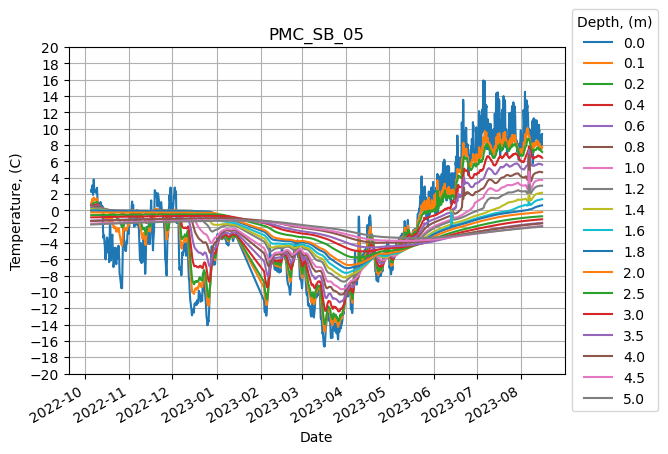

In [3]:
PMC_SB_05_old = pd.read_csv("PMC_SB_05_old.csv")

PMC_SB_05_old["time"]= pd.to_datetime(
  PMC_SB_05_old["time"], format='%d/%m/%Y %H:%M')

PMC_SB_05_old["time"]=PMC_SB_05_old["time"].dt.tz_localize('CET')

PMC_SB_05=pd.concat([PMC_SB_05_old, df])

fix, ax = plt.subplots() # create plot
PMC_SB_05.groupby("depth").plot(ax=ax,x="time",y="value", title="PMC_SB_05")

ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
plt.grid()

ax.set_ylim(-20,20)
ax.set_xlabel("Date") # set labels
ax.set_ylabel("Temperature, (C)")
ax.legend(df["depth"], loc="center left", bbox_to_anchor=(1, 0.5), title="Depth, (m)")

In [4]:
PMC_SB_05_tz_naive=PMC_SB_05

PMC_SB_05_tz_naive["time"]=PMC_SB_05_tz_naive["time"].dt.tz_localize(None)

PMC_SB_05_tz_naive

PMC_SB_05_tz_naive.pivot(index='depth', columns='time', values='value').to_csv('PMC_SB_05.csv')